In [8]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import argparse
import numpy as np
import cv2
import matplotlib.gridspec as gridspec
import glob
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from PIL import Image
from matplotlib import cm
from matplotlib import colors
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

import scipy.stats
from sklearn import mixture

import pandas as pd

In [9]:
def plot(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, interpolation='nearest')

In [10]:
def RGB(red,green,blue): return '#%02x%02x%02x' % (red,green,blue)

In [11]:
def colorPixels(img):
    img = cv2.imread(img) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img)
    pixel_colors = img.reshape((np.shape(img)[0]*np.shape(img)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()
    
    return pixel_colors

In [12]:
def GMM_Cluster_Prob(imgData, clusters):
    
    gmm_ = GaussianMixture(n_components = clusters)
    labels = gmm_.fit_predict(imgData)
    
    centers = np.empty(shape=(gmm_.n_components, imgData.shape[1]))
    
    for i in range(gmm_.n_components):
        density = scipy.stats.multivariate_normal(cov=gmm_.covariances_[i], mean=gmm_.means_[i]).logpdf(imgData)
        centers[i, :] = imgData[np.argmax(density)]
    
    #print("Posterior probability of data belongingness to each Gaussian")  
    probs = gmm_.predict_proba(imgData)
    probs = probs.round(3)
    
    return labels, centers, probs

In [156]:
def plotColorHist(image_newdf):
    clusters = image_newdf["Cluster Labels"].tolist()  
    count    = image_newdf["#Pixels"].tolist()  
    colors   = [ RGB(r, g, b) for r, g, b in zip(image_newdf["Mean R"], image_newdf["Mean G"], image_newdf["Mean B"]) ]

    #print("The plot below shows the dominance of clusters interms of their number and color.", colors)
    
    plt.figure(figsize=(16,8))
    ax1 = plt.subplot(121, aspect='equal')
    image_newdf.plot(kind='pie', y = 'Updated Probabilities', ax=ax1, autopct='%1.1f%%', colors = colors,
     startangle=90, shadow=False, labels=image_newdf['Cluster Labels'], legend = True, fontsize=14)
    
     
    #ax1 = plt.subplot(122, aspect='equal')
    '''image_newdf.plot(kind='pie', y = 'Pixel belonging probability', ax=ax1, autopct='%1.1f%%', colors = colors,
     startangle=90, shadow=False, labels=image_newdf['Cluster Labels'], legend = True, fontsize=14)'''

    #Updated Probabilities...are
    '''width = 0.90
    fig, ax = plt.subplots()
    a = ax.bar(clusters, count, width, color = colors) # plot a vals

    plt.show() '''
    return colors

In [40]:
def GenerateProb(prob):
    meanProb = prob.mean(axis = 0)
    #print("Mean probability of pixel belongingness to each gaussian cluster.")
    #print(meanProb)
    return meanProb

In [157]:
def createDataFrame(image_df, probabilities):
    image_newdf = pd.DataFrame()
    sortedLabels = sorted(image_df['Cluster Labels'].unique())
    #print("A new Dataframe with Mean R, G, B values and Pixel count grouped by their cluster labels.")
    for label in sortedLabels:
        d = image_df[image_df['Cluster Labels'] == label]
        count = d[0].count()
        temp = pd.DataFrame(
            {
                'Cluster Labels': "Cluster " + str(label),
                '#Pixels': count,
                'Mean R' : int(d[0].mean()),
                'Mean G' : int(d[1].mean()),
                'Mean B' : int(d[2].mean()),
                'Pixel belonging probability' : probabilities[label]
            }, index=[0]
        )
        image_newdf = pd.concat([image_newdf, temp], ignore_index=True)
        
        
    mask_cluster_index = image_newdf[((image_newdf['Mean R'] == 0) &( image_newdf['Mean G'] == 0) & (image_newdf['Mean B'] == 0))].index.values

    print(mask_cluster_index[0])
    print("Original DF")
    print(image_newdf)
    new_image_newdf = image_newdf.drop(mask_cluster_index[0])

    total = new_image_newdf['#Pixels'].sum()
    print(total)
    print("Dropped DF")
    print(new_image_newdf)

    pixels_list = new_image_newdf['#Pixels'].tolist()
    print(pixels_list)

    update_prob = [ t/total for t in pixels_list ]
    print(update_prob)
        
    new_image_newdf['Updated Probabilities'] = update_prob
        
    
    print("New DF")
    print(new_image_newdf) 
    
    #print("mask_cluster_index is : ", mask_cluster_index)
    
    return new_image_newdf


In [42]:
def scatterPlot(centers, reshapedImage, colors):
    fig2 = plt.figure(figsize = (12, 50))
    axis = fig2.add_subplot(4, 1, 1, projection="3d")
    axis.scatter(reshapedImage[:, 0], reshapedImage[:, 1], reshapedImage[:, 2], facecolors= colors, marker=".")
    axis.scatter(centers[:, 0], centers[:, 1], centers[:, 2], marker="o", facecolor ='RED',  s = 200)
    
    plt.show()

# Half-Ripe Mango Clustering Analysis

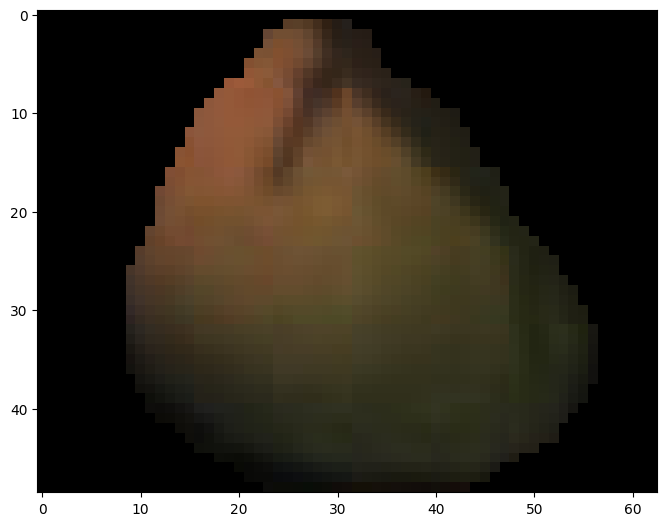

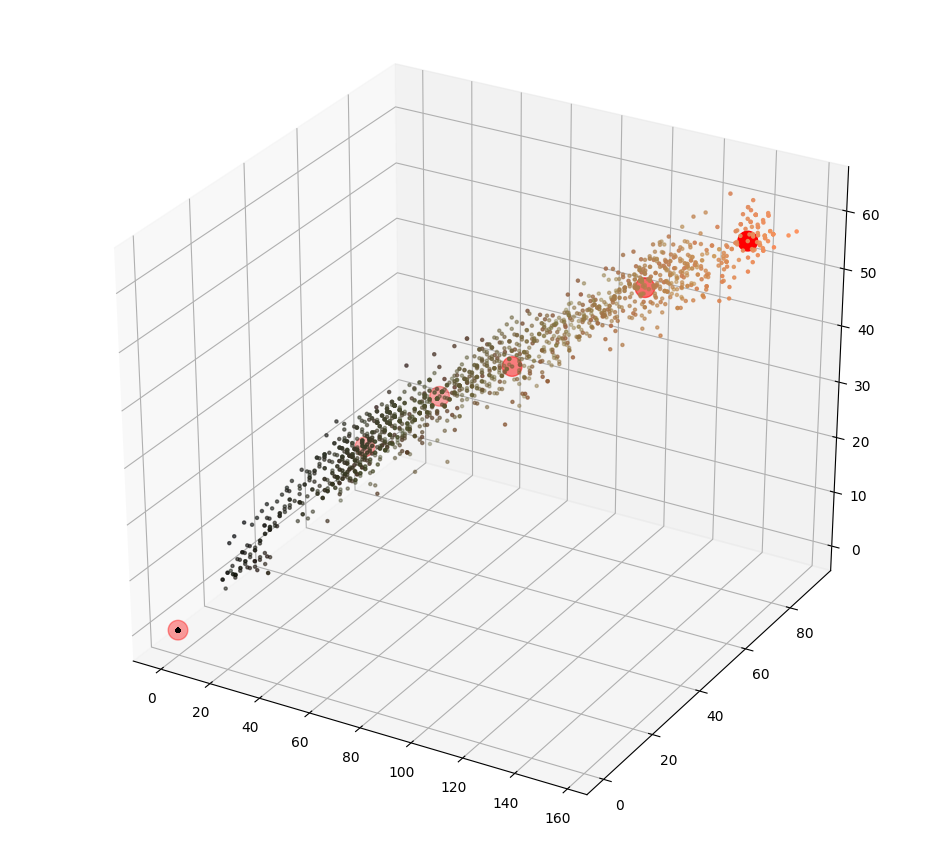

Mean probability of pixel belongingness to each gaussian cluster.
[0.468092   0.19621477 0.11245546 0.12284548 0.03235795 0.06802235]
0
Original DF
  Cluster Labels  #Pixels  Mean R  Mean G  Mean B  Pixel belonging probability
0      Cluster 0     1445       0       0       0                     0.468092
1      Cluster 1      599      56      50      30                     0.196215
2      Cluster 2      359     109      78      47                     0.112455
3      Cluster 3      426      34      35      22                     0.122845
4      Cluster 4      103     139      86      55                     0.032358
5      Cluster 5      155      73      53      35                     0.068022
1642
Dropped DF
  Cluster Labels  #Pixels  Mean R  Mean G  Mean B  Pixel belonging probability
1      Cluster 1      599      56      50      30                     0.196215
2      Cluster 2      359     109      78      47                     0.112455
3      Cluster 3      426      34      35     

['#38321e', '#6d4e2f', '#222316', '#8b5637', '#493523']

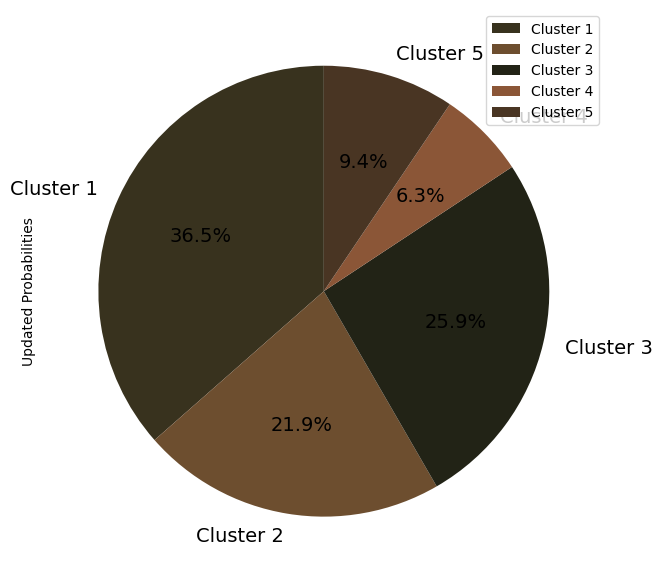

In [161]:
from matplotlib import colors

imagePath = "halfRipe.png"
clusters = 6

mng_img = cv2.imread(imagePath)
mng_img = cv2.cvtColor(mng_img, cv2.COLOR_BGR2RGB)  # COnvert to RGB COlor Space.

plot(mng_img)

mng_img_re = mng_img.reshape((mng_img.shape[0] * mng_img.shape[1], 3))  # Reshape the 3-channel image to cluster

labels, centers, probs = GMM_Cluster_Prob(mng_img_re, clusters)

image_df = pd.DataFrame(mng_img_re) 
# Add the Cluster Labels column to Reshaped Image dataframe
image_df['Cluster Labels']= labels  
# Picks the color pof pixels for scatter plot
colors_ = colorPixels(imagePath)

scatterPlot(centers, mng_img_re, colors_)
# Generates the mean probability that a pixel belongs to a cluster
probability_list = GenerateProb(probs)
# Creates a New Dataframe with #Pixels corresponding to each cluster and their mean R, G, B values.
updated_image_df = createDataFrame(image_df, probability_list)   
# Plots the n(= clusters) dominant colors in the image.
plotColorHist(updated_image_df)




# Ripe Mango Clustering Analysis

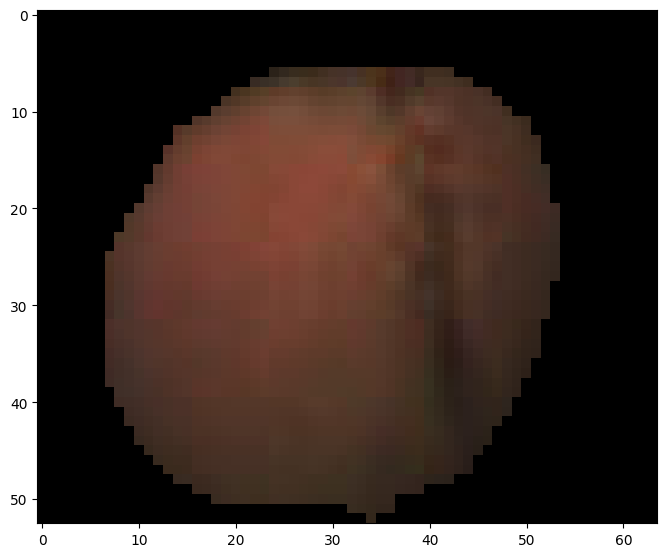

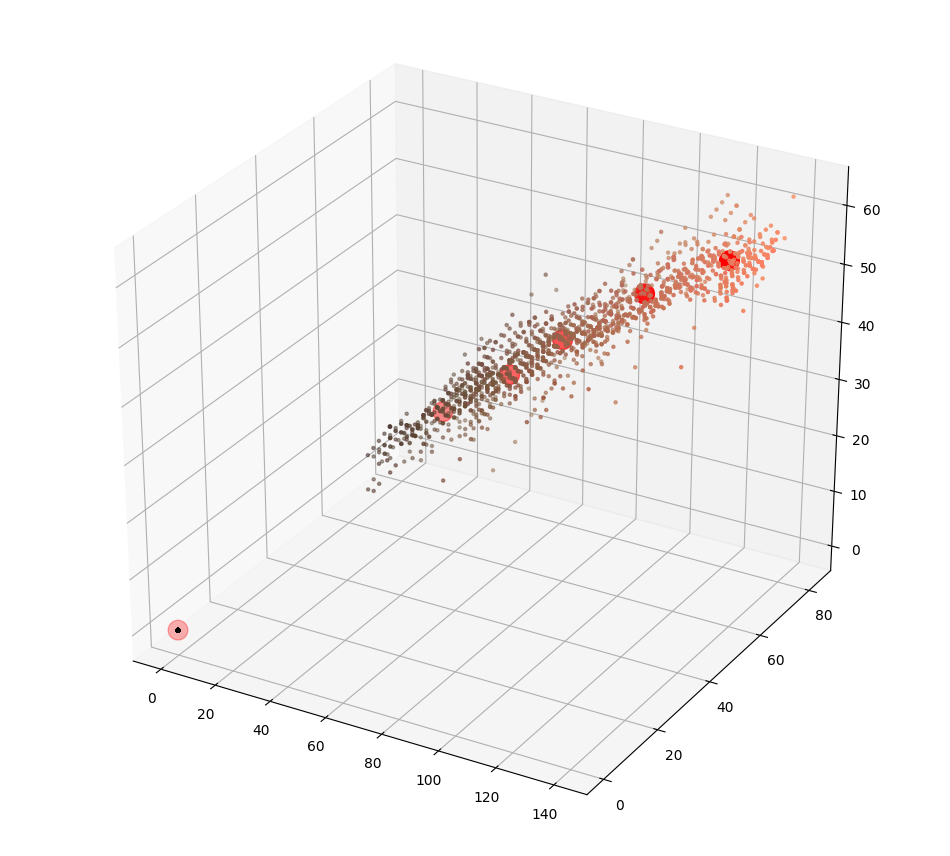

Mean probability of pixel belongingness to each gaussian cluster.
[0.48142689 0.1108293  0.1248125  0.0774546  0.08971993 0.11574794]
0
Original DF
  Cluster Labels  #Pixels  Mean R  Mean G  Mean B  Pixel belonging probability
0      Cluster 0     1633       0       0       0                     0.481427
1      Cluster 1      364     106      62      48                     0.110829
2      Cluster 2      385      71      46      36                     0.124812
3      Cluster 3      263     127      71      53                     0.077455
4      Cluster 4      328      55      40      30                     0.089720
5      Cluster 5      419      85      55      41                     0.115748
1759
Dropped DF
  Cluster Labels  #Pixels  Mean R  Mean G  Mean B  Pixel belonging probability
1      Cluster 1      364     106      62      48                     0.110829
2      Cluster 2      385      71      46      36                     0.124812
3      Cluster 3      263     127      71     

['#6a3e30', '#472e24', '#7f4735', '#37281e', '#553729']

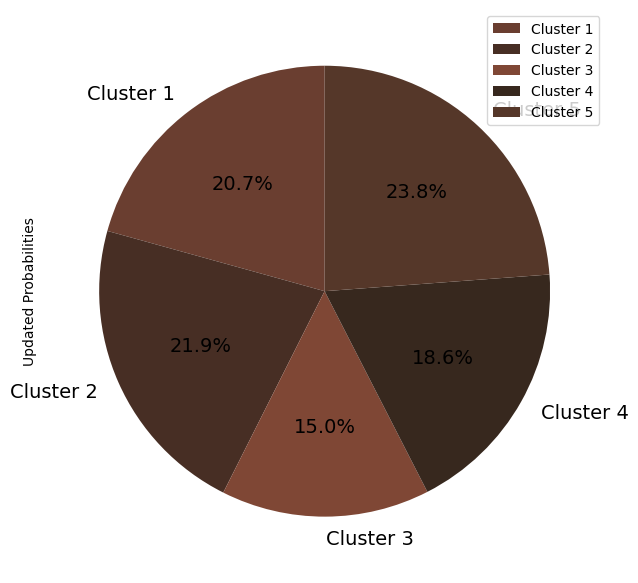

In [160]:
from matplotlib import colors

imagePath = "fullyRipe.png"
clusters = 6

mng_img = cv2.imread(imagePath)
mng_img = cv2.cvtColor(mng_img, cv2.COLOR_BGR2RGB)  # COnvert to RGB COlor Space.

plot(mng_img)

mng_img_re = mng_img.reshape((mng_img.shape[0] * mng_img.shape[1], 3))  # Reshape the 3-channel image to cluster

labels, centers, probs = GMM_Cluster_Prob(mng_img_re, clusters)

image_df = pd.DataFrame(mng_img_re) 
# Add the Cluster Labels column to Reshaped Image dataframe
image_df['Cluster Labels']= labels  
# Picks the color pof pixels for scatter plot
colors_ = colorPixels(imagePath)

scatterPlot(centers, mng_img_re, colors_)

# Generates the mean probability that a pixel belongs to a cluster
probability_list = GenerateProb(probs)
# Creates a New Dataframe with #Pixels corresponding to each cluster and their mean R, G, B values.
updated_image_df = createDataFrame(image_df, probability_list)   
# Plots the n(= clusters) dominant colors in the image.
plotColorHist(updated_image_df)



# Raw Mango Clustering Analysis

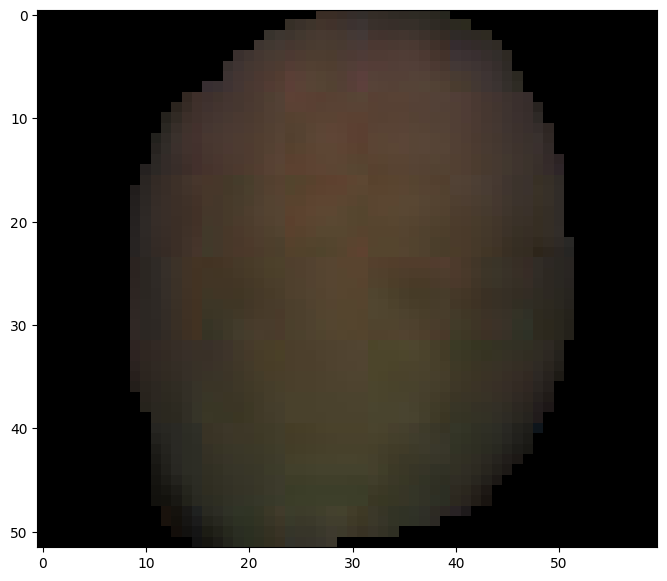

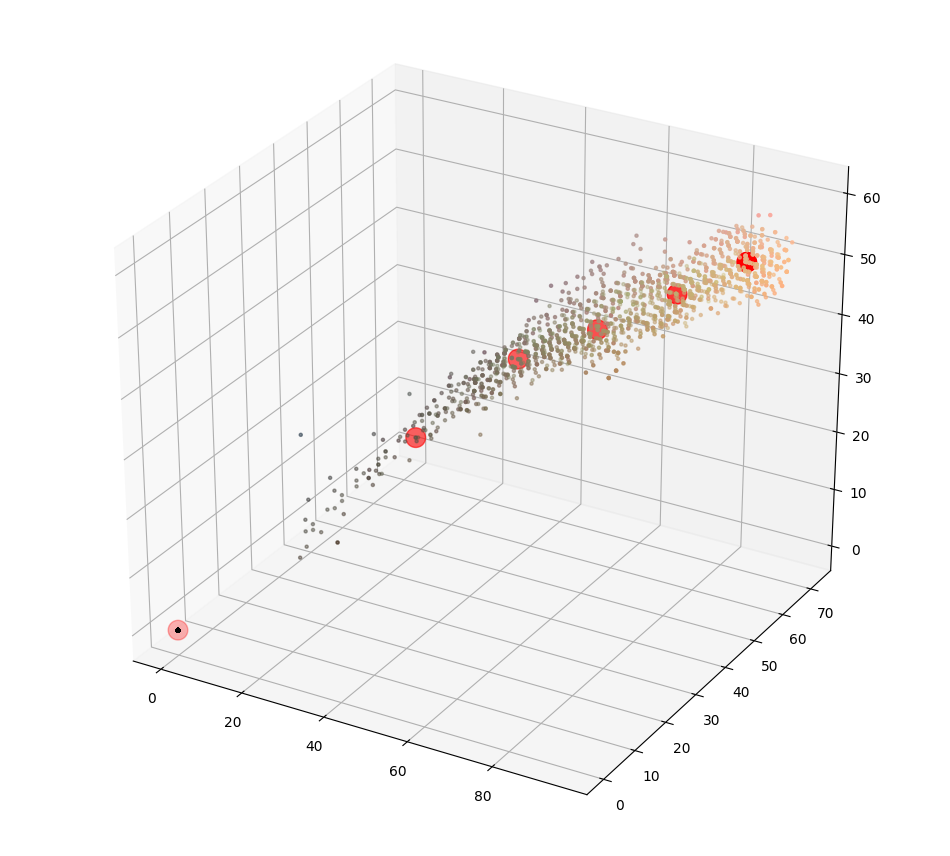

Mean probability of pixel belongingness to each gaussian cluster.
[0.3974359  0.16009135 0.13400128 0.1160391  0.1641     0.02831827]
0
Original DF
  Cluster Labels  #Pixels  Mean R  Mean G  Mean B  Pixel belonging probability
0      Cluster 0     1240       0       0       0                     0.397436
1      Cluster 1      504      59      52      40                     0.160091
2      Cluster 2      431      86      66      49                     0.134001
3      Cluster 3      361      46      42      35                     0.116039
4      Cluster 4      508      73      60      44                     0.164100
5      Cluster 5       76      30      27      23                     0.028318
1880
Dropped DF
  Cluster Labels  #Pixels  Mean R  Mean G  Mean B  Pixel belonging probability
1      Cluster 1      504      59      52      40                     0.160091
2      Cluster 2      431      86      66      49                     0.134001
3      Cluster 3      361      46      42     

['#3b3428', '#564231', '#2e2a23', '#493c2c', '#1e1b17']

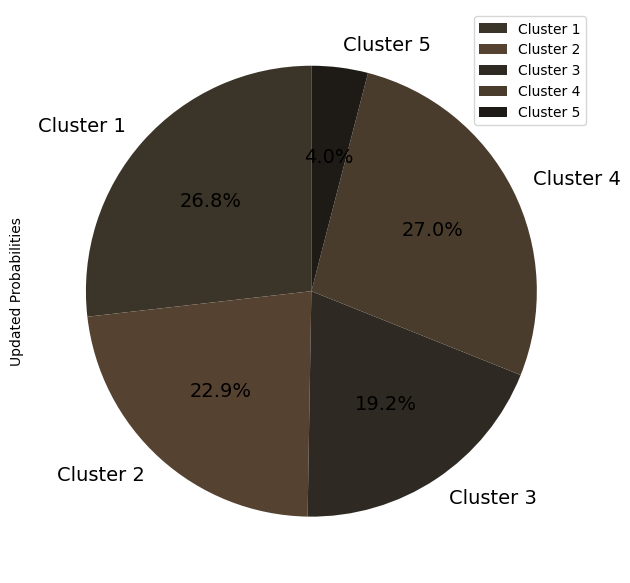

In [159]:
from matplotlib import colors

imagePath = "Raw.png"
clusters = 6

mng_img = cv2.imread(imagePath)
mng_img = cv2.cvtColor(mng_img, cv2.COLOR_BGR2RGB)  # COnvert to RGB COlor Space.

plot(mng_img)

mng_img_re = mng_img.reshape((mng_img.shape[0] * mng_img.shape[1], 3))  # Reshape the 3-channel image to cluster

labels, centers, probs = GMM_Cluster_Prob(mng_img_re, clusters)

image_df = pd.DataFrame(mng_img_re) 
# Add the Cluster Labels column to Reshaped Image dataframe
image_df['Cluster Labels']= labels  
# Picks the color pof pixels for scatter plot
colors_ = colorPixels(imagePath)

scatterPlot(centers, mng_img_re, colors_) 

# Generates the mean probability that a pixel belongs to a cluster
probability_list = GenerateProb(probs)
# Creates a New Dataframe with #Pixels corresponding to each cluster and their mean R, G, B values.
updated_image_df = createDataFrame(image_df, probability_list)   
# Plots the n(= clusters) dominant colors in the image.
plotColorHist(updated_image_df)


In [20]:
!pwd

/Users/pavankumar/Documents/Robotics MSc/Dissertation/Fruit-Detection-in-Orchards/Ripeness Analysis


# PIE PLOT Clustering

Mean probability of pixel belongingness to each gaussian cluster.
[0.16009135 0.3974359  0.13400128 0.1641     0.1160391  0.02831827]
1
Original DF
  Cluster Labels  #Pixels  Mean R  Mean G  Mean B  Pixel belonging probability
0      Cluster 0      504      59      52      40                     0.160091
1      Cluster 1     1240       0       0       0                     0.397436
2      Cluster 2      431      86      66      49                     0.134001
3      Cluster 3      508      73      60      44                     0.164100
4      Cluster 4      361      46      42      35                     0.116039
5      Cluster 5       76      30      27      23                     0.028318
1880
Dropped DF
  Cluster Labels  #Pixels  Mean R  Mean G  Mean B  Pixel belonging probability
0      Cluster 0      504      59      52      40                     0.160091
2      Cluster 2      431      86      66      49                     0.134001
3      Cluster 3      508      73      60     

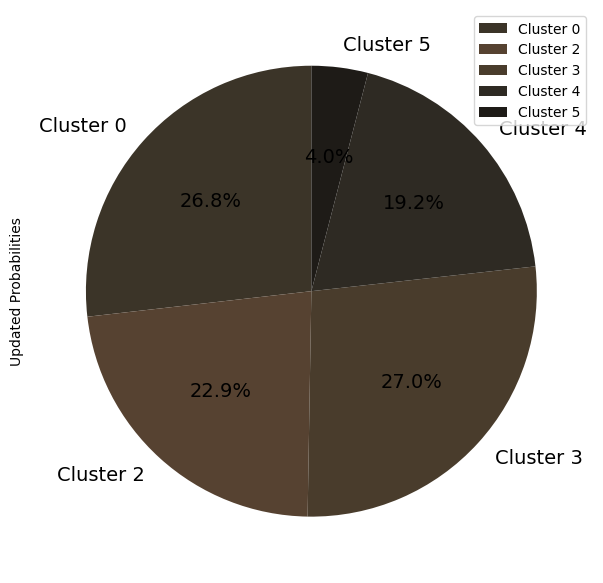

In [158]:
from matplotlib import colors

imagePath = "Raw.png"
clusters = 6

mng_img = cv2.imread(imagePath)
mng_img = cv2.cvtColor(mng_img, cv2.COLOR_BGR2RGB)  # COnvert to RGB COlor Space.

#plot(mng_img)

mng_img_re = mng_img.reshape((mng_img.shape[0] * mng_img.shape[1], 3))  # Reshape the 3-channel image to cluster

labels, centers, probs = GMM_Cluster_Prob(mng_img_re, clusters)

image_df = pd.DataFrame(mng_img_re) 
# Add the Cluster Labels column to Reshaped Image dataframe
image_df['Cluster Labels']= labels  
# Picks the color pof pixels for scatter plot
colors_ = colorPixels(imagePath)

#scatterPlot(centers, mng_img_re, colors_)  

# Generates the mean probability that a pixel belongs to a cluster
probability_list = GenerateProb(probs)

# Creates a New Dataframe with #Pixels corresponding to each cluster and their mean R, G, B values.
updated_image_df = createDataFrame(image_df, probability_list)   
# Plots the n(= clusters) dominant colors in the image.
#mask_cluster_index = image_newdf[((image_newdf['Mean R'] == 0) &( image_newdf['Mean G'] == 0) & (image_newdf['Mean B'] == 0))].index

print(updated_image_df.to_latex(index=False))

# plot chart
cluster_colors = plotColorHist(updated_image_df)
#print(cluster_colors)






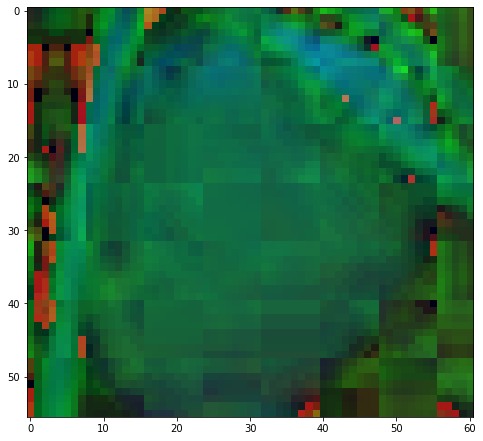

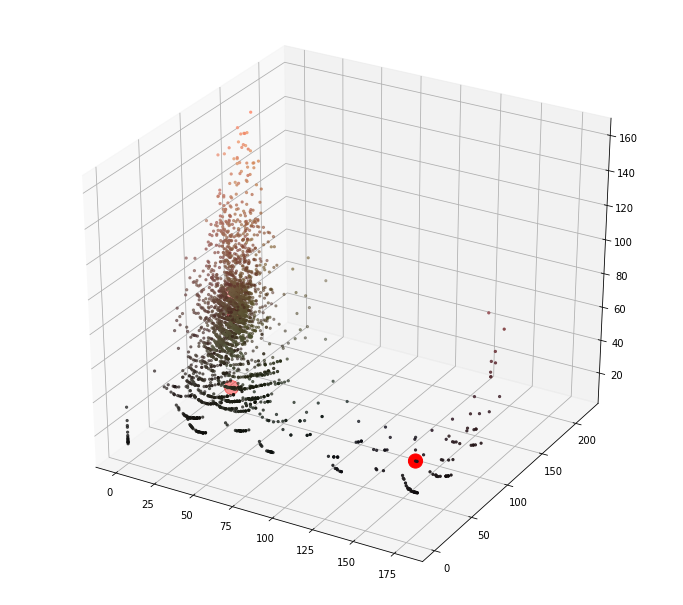

   Cluster Labels  #Pixels  Mean R  Mean G  Mean B
0               0     1436      20      97      61
0               1     1021       8     116      70
0               2      117     155      57      26
0               3      842      30      69      26
The plot below shows the dominance of clusters interms of their number and color. ['#14613d', '#087446', '#9b391a', '#1e451a']


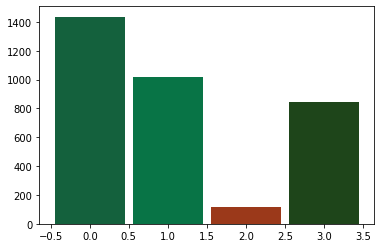

Mean probability of pixel belongingness to each gaussian cluster.
[0.42093179 0.29293326 0.03549707 0.25062383]


array([0.42093179, 0.29293326, 0.03549707, 0.25062383])

In [15]:
from matplotlib import colors

imagePath = "test.jpg"
clusters = 4

mng_img = cv2.imread(imagePath)
mng_img = cv2.cvtColor(mng_img, cv2.COLOR_BGR2HSV)  # COnvert to RGB COlor Space.

plot(mng_img)

mng_img_re = mng_img.reshape((mng_img.shape[0] * mng_img.shape[1], 3))  # Reshape the 3-channel image to cluster

labels, centers, probs = GMM_Cluster_Prob(mng_img_re, clusters)

image_df = pd.DataFrame(mng_img_re) 
# Add the Cluster Labels column to Reshaped Image dataframe
image_df['Cluster Labels']= labels  
# Picks the color pof pixels for scatter plot
colors_ = colorPixels(imagePath)

scatterPlot(centers, mng_img_re, colors_)  
# Creates a New Dataframe with #Pixels corresponding to each cluster and their mean R, G, B values.
image_newdf = createDataFrame(image_df)   
# Plots the n(= clusters) dominant colors in the image.
plotColorHist(image_newdf)
# Generates the mean probability that a pixel belongs to a cluster
GenerateProb(probs)

# 3D Scatter Plots in 4 color spaces.

In [1]:
def colorPixels(img):
    img = cv2.imread(img) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    pixel_colors = img.reshape((np.shape(img)[0]*np.shape(img)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    
    return pixel_colors
    

In [95]:
def showScatterPlot(imgPath, colors):
    
    colorSpace = [cv2.COLOR_BGR2RGB, cv2.COLOR_BGR2LAB, cv2.COLOR_BGR2YCrCb, cv2.COLOR_BGR2HSV]
    cs_string = ["R G B", "L A B", "Y Cr Cb", "H S V"]
    num = 1
    
    for cs in colorSpace:
        
        mng = cv2.imread(imgPath)
        mng = cv2.cvtColor(mng, cs)
        
        #show(mng)
        r, g, b = cv2.split(mng)
        fig = plt.figure(figsize = (15, 50))
        axis = fig.add_subplot(4, 1, num, projection="3d")
        #fig.add_subplot(4, 1, num, projection="3d")
        
        axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors= colors, s=15, marker="o")
        labelList = cs_string[num - 1].split()
        axis.set_xlabel(labelList[0])
        axis.set_ylabel(labelList[1])
        axis.set_zlabel(labelList[2])
        plt.show()
        
        num = num + 1

# Raw Mango - Scatterplot 

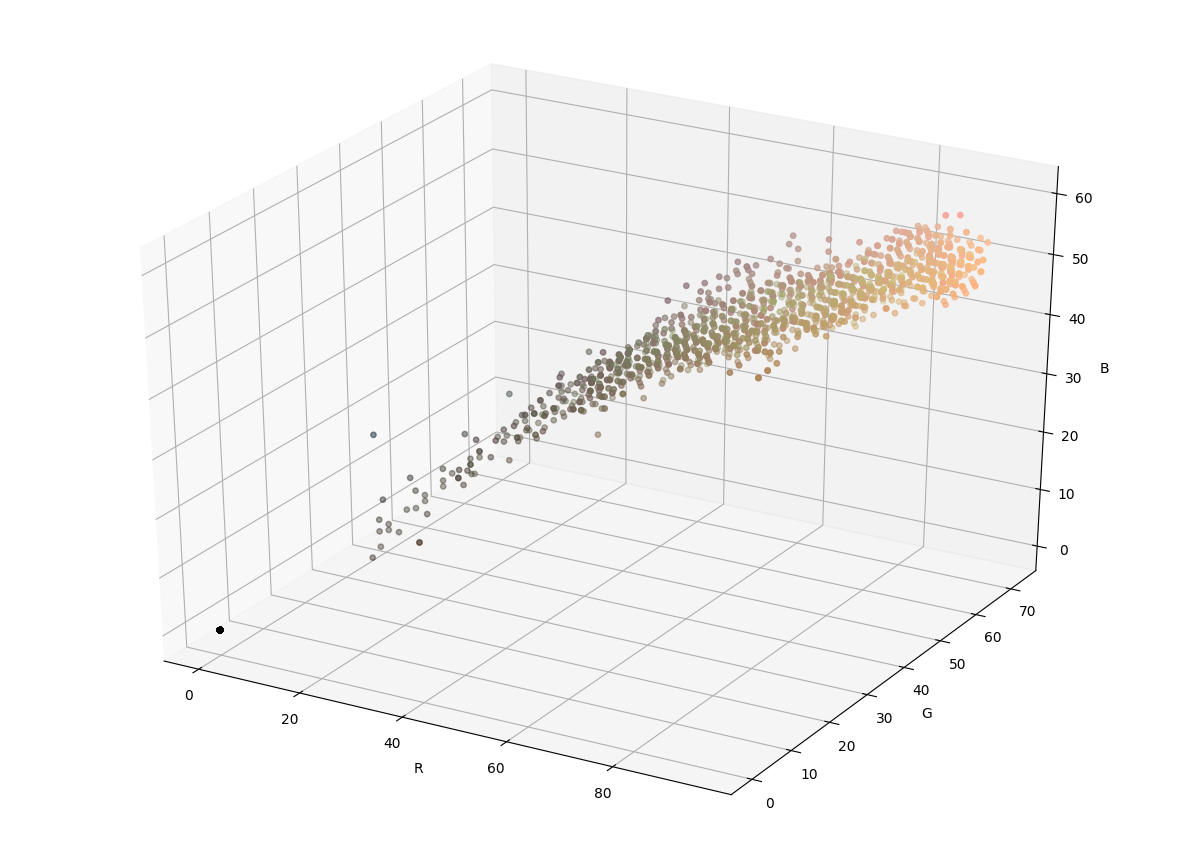

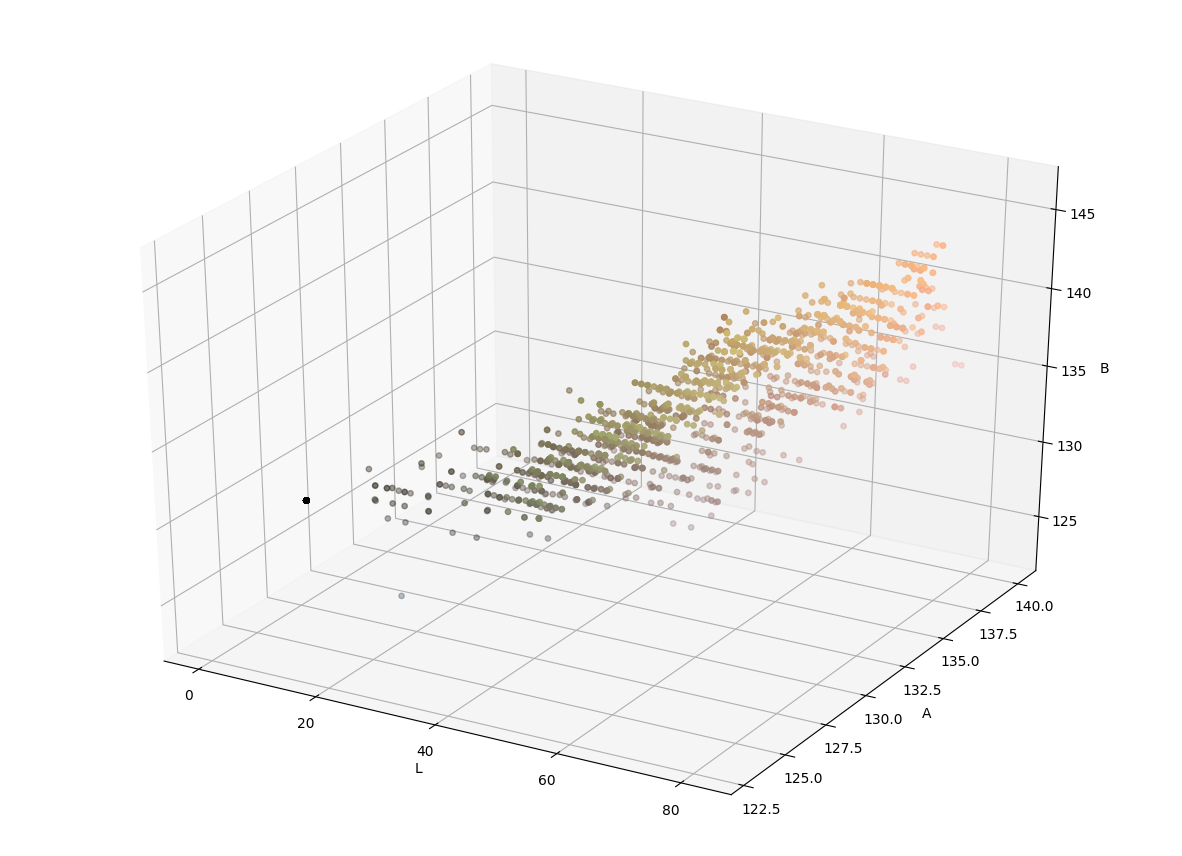

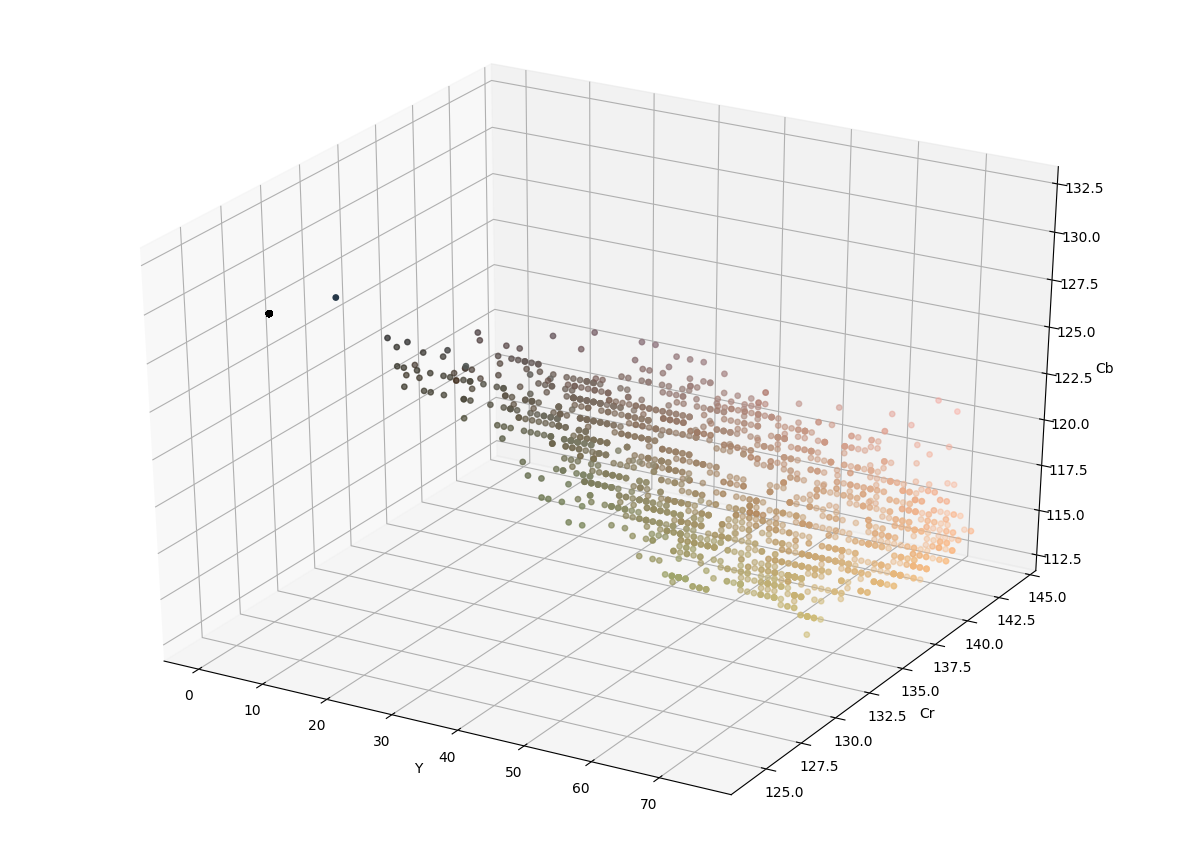

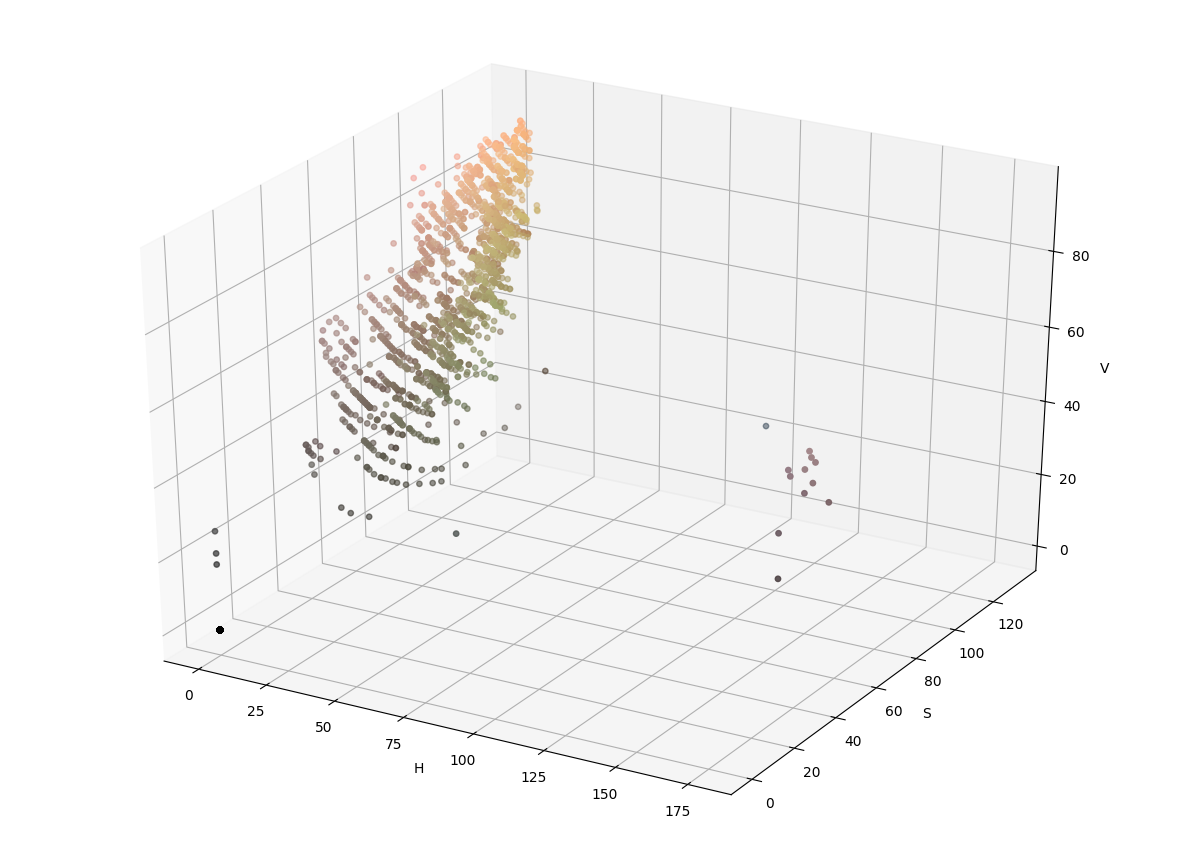

In [96]:
image = "Raw.png"
pixels_color = colorPixels(image)
showScatterPlot(image, pixels_color)

# Ripe Mango - Scatter plot 


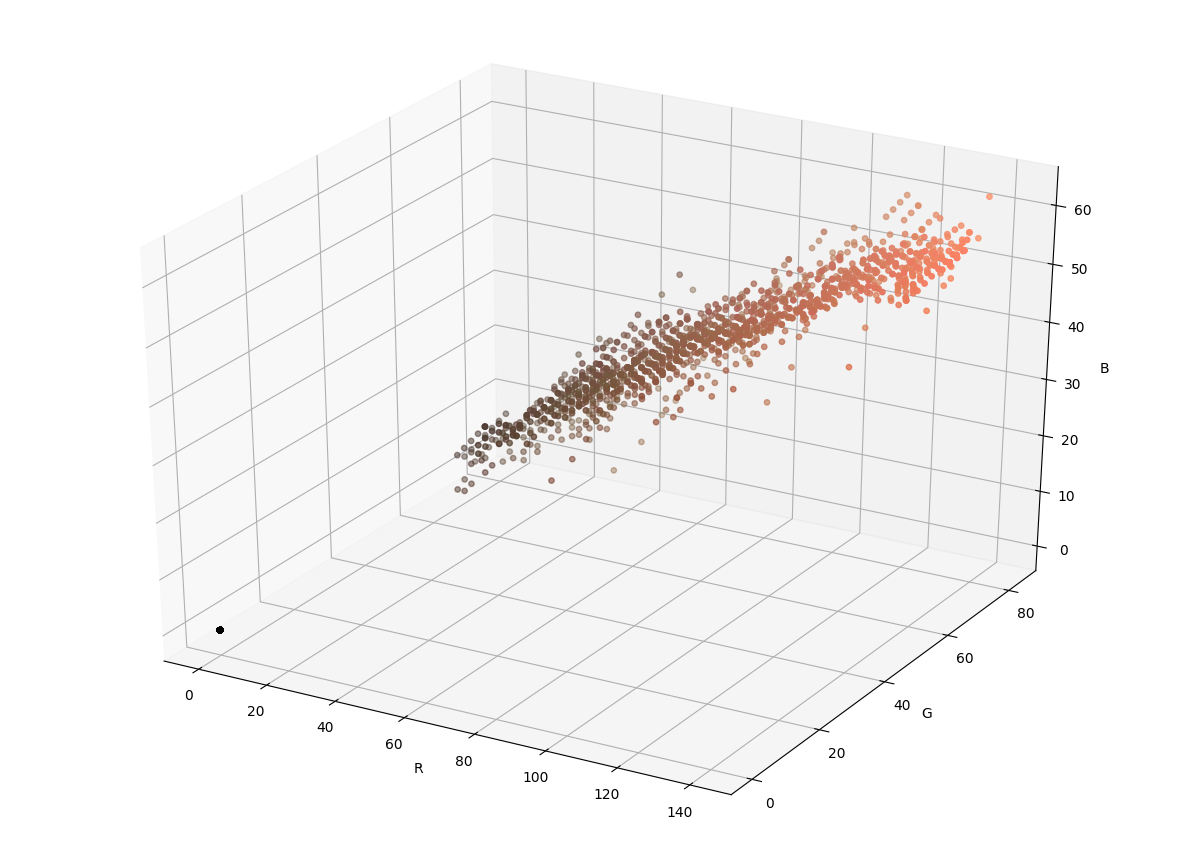

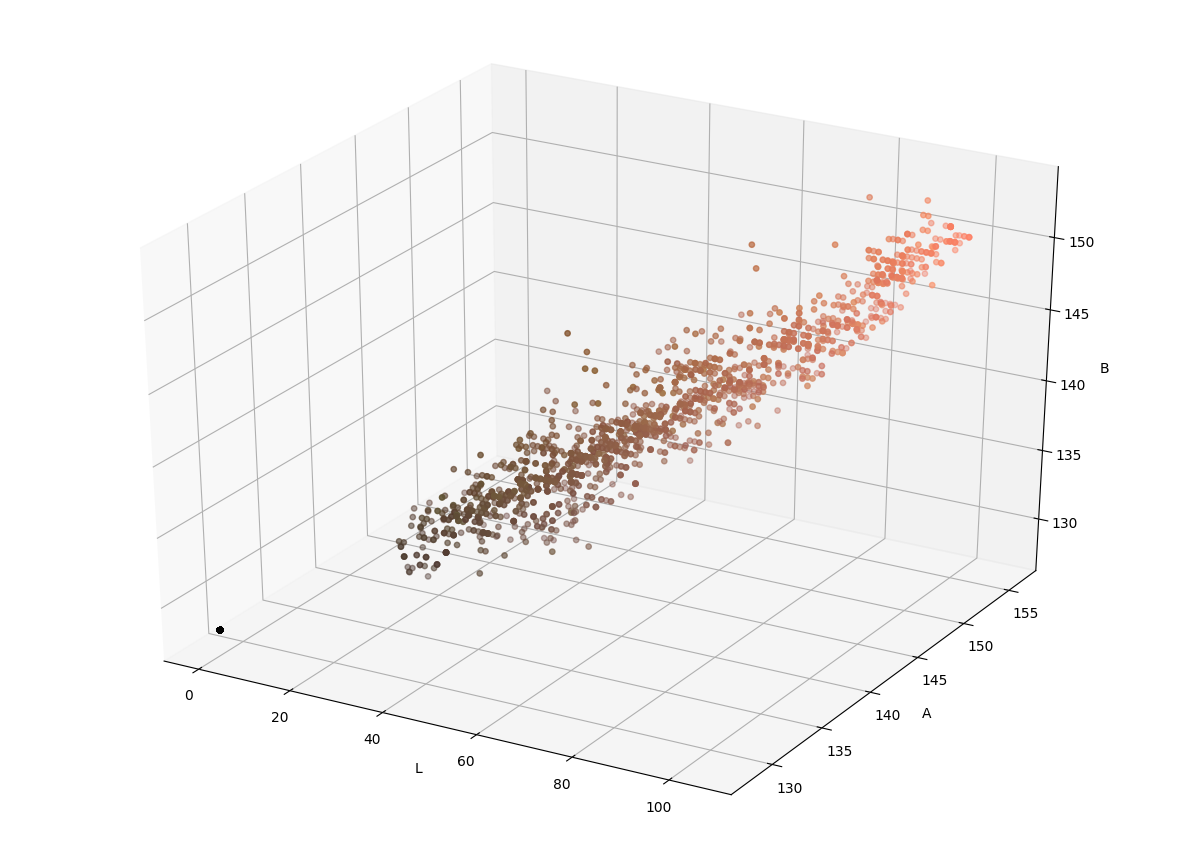

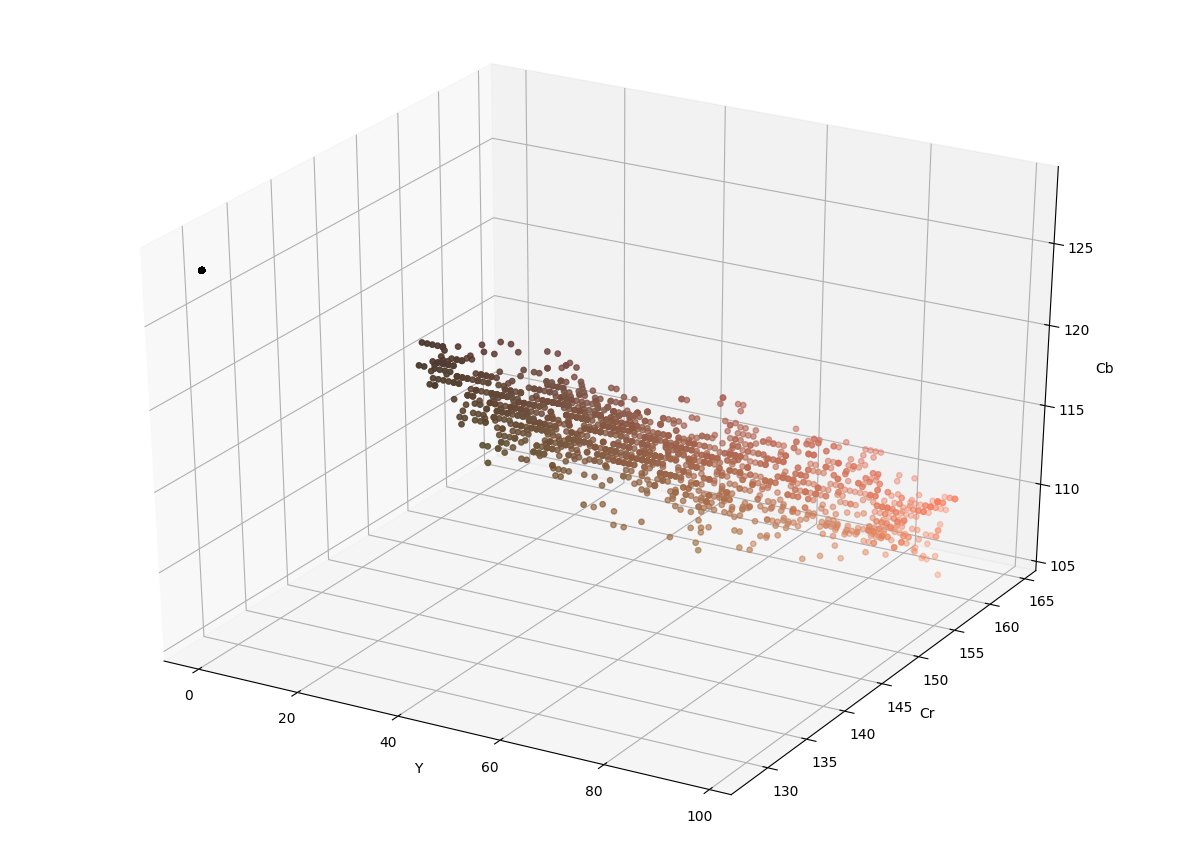

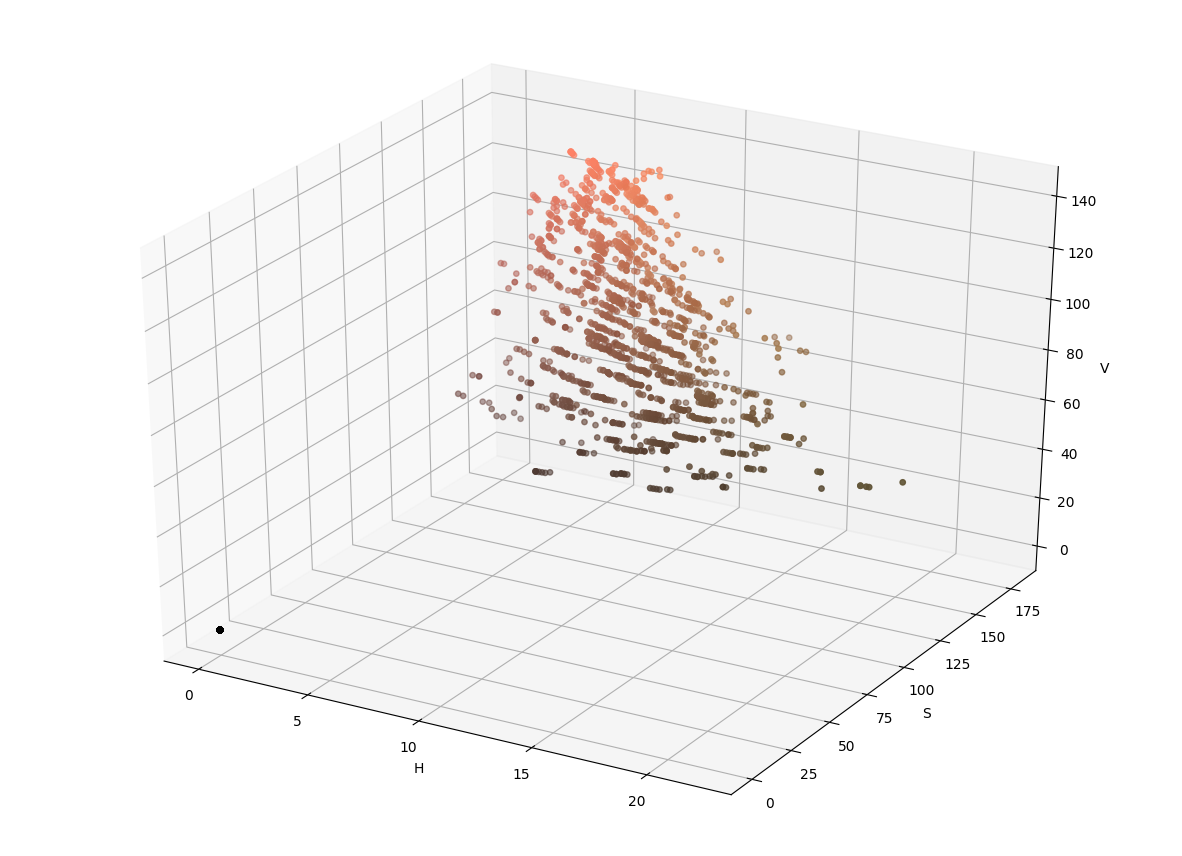

In [97]:
image = "fullyRipe.png"
pixels_color = colorPixels(image)
showScatterPlot(image, pixels_color)

# Half-Ripe Mango - Scatter plot 

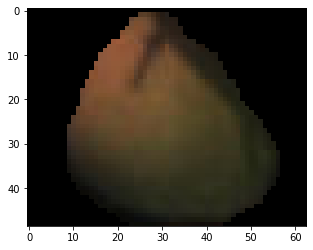

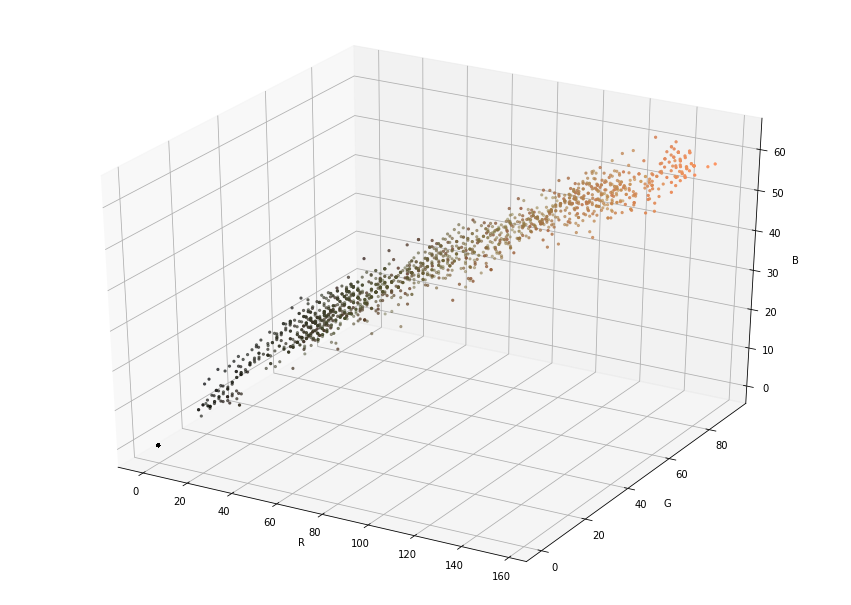

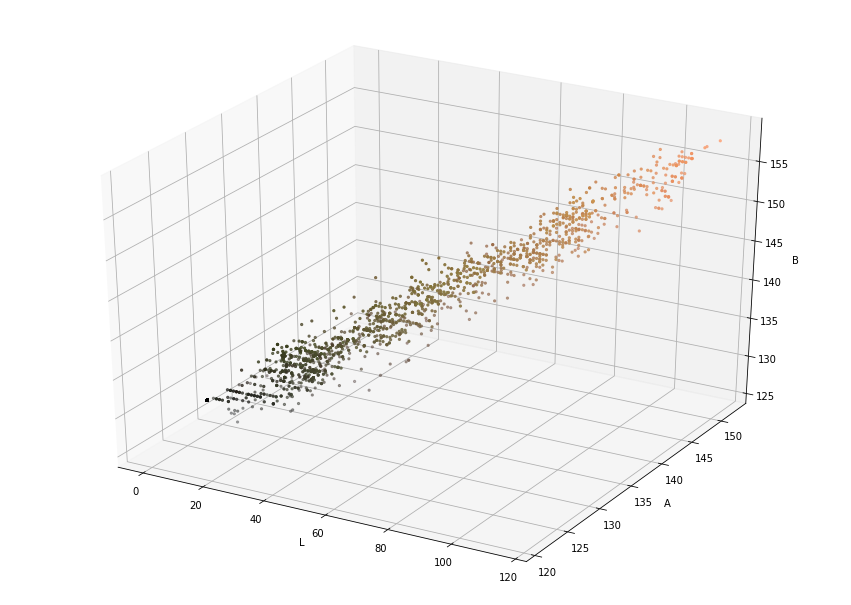

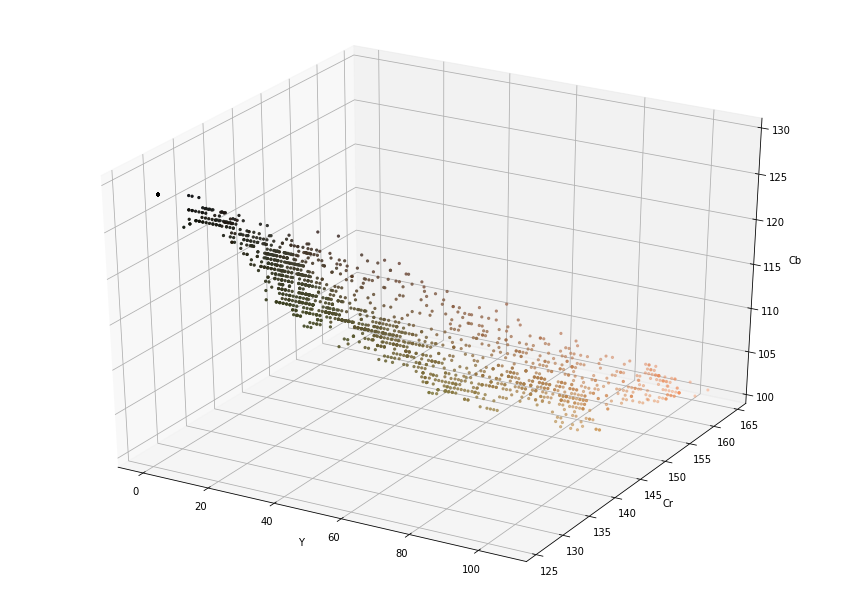

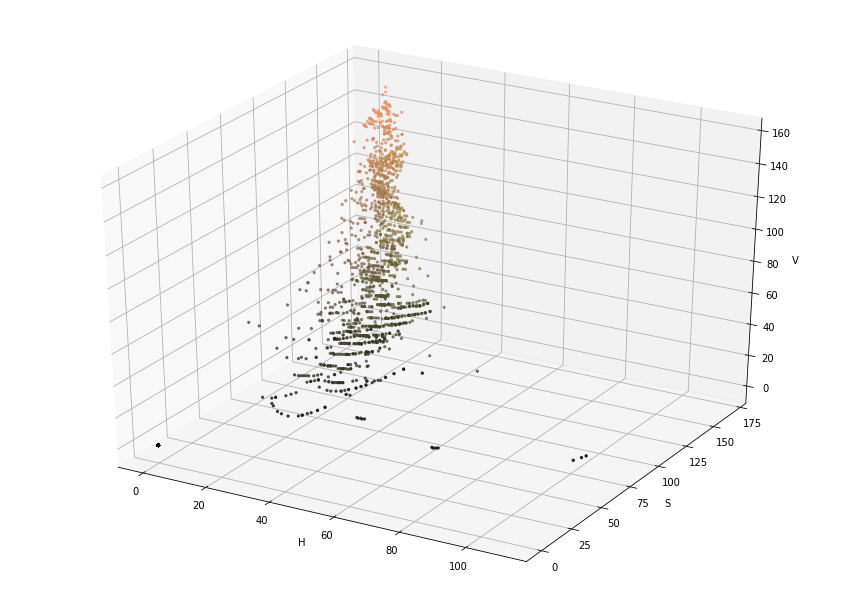

In [56]:
pixels_color = colorPixels("halfRipe.png")
showScatterPlot("halfRipe.png", pixels_color)

# Edge Detection

In [3]:
def auto_canny(image, sigma):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	# return the edged image
	return edged

In [12]:
%cd Ripen

/Users/pavankumar/Documents/Robotics MSc/Dissertation/Fruit-Detection-in-Orchards/Ripeness Analysis/Ripen


(40, 58, 3)


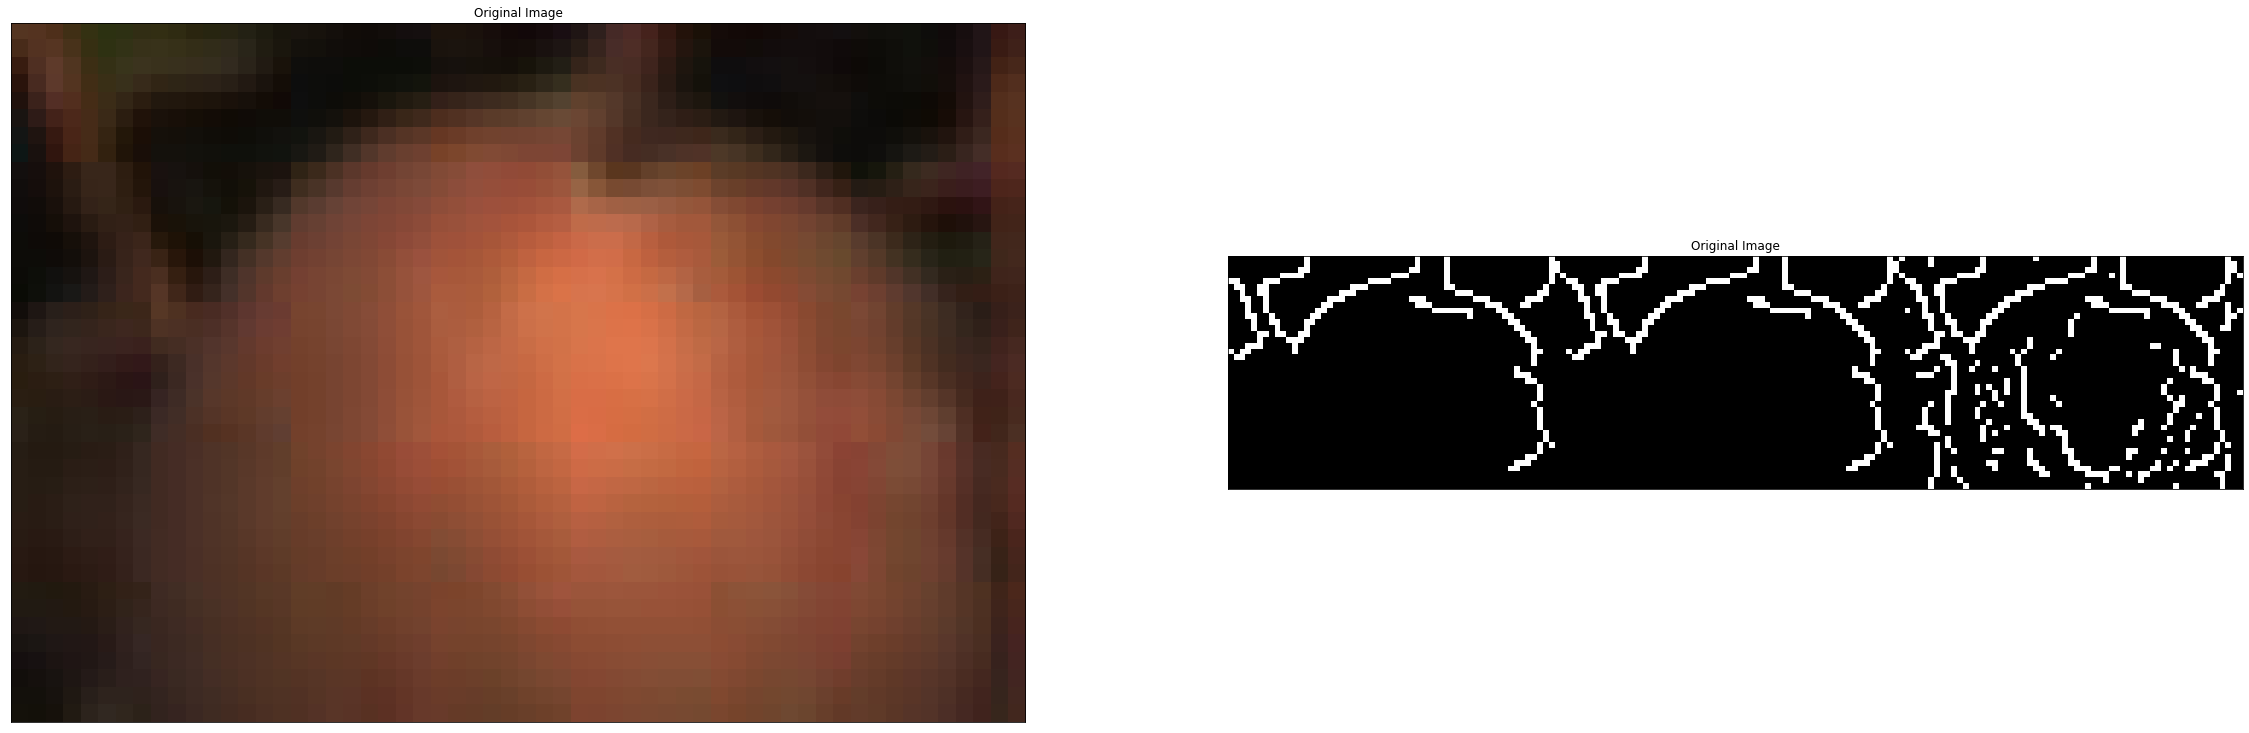

'/Users/pavankumar/Documents/Robotics MSc/Dissertation/Fruit-Detection-in-Orchards/Ripeness Analysis/Ripen'

In [44]:
folder = "Ripen" 
imagePath = "img_1_5_0_Mangos.jpg (1).jpg"

image = cv2.imread(imagePath) 
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.blur(gray,(9,9))
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

blurred = cv2.equalizeHist(blurred)

# apply Canny edge detection using a wide threshold, tight
# threshold, and automatically determined threshold

auto = auto_canny(blurred, 0.33)
wide = cv2.Canny(blurred, 10, 200)
tight = cv2.Canny(blurred, 50, 50)

print(image_rgb.shape)


images = np.hstack(( auto, wide, tight))

fig2 = plt.figure(figsize = (40,40))
plt.subplot(121),plt.imshow(image_rgb)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(images, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.show()

%pwd

          a         b         c
0  0.654982  0.032029  0.978175
1  0.333857  0.935319  0.889333
2  0.597000  0.678121  0.597027
3  0.548814  0.938209  0.116362
4  0.552677  0.254372  0.055295
5  0.631624  0.801852  0.374998
6  0.295450  0.828077  0.941619
7  0.890659  0.363443  0.769530
8  0.932551  0.061073  0.944775
9  0.835160  0.759796  0.313761


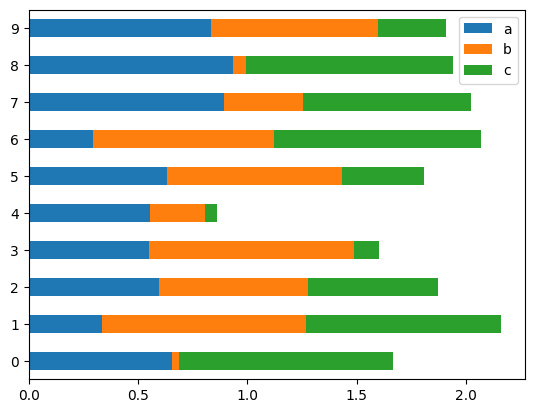

In [7]:
import pandas as pd
import numpy as np

df2 = pd.DataFrame(np.random.rand(10, 3), columns=['a', 'b', 'c'])
print (df2)
df2.plot.barh(stacked=True);